# Acetate Production: iCH360 vs iML1515
In this notebook, we investigate the mismatch in acetate production between iml1515 and its genome-scale parent iML1515.

In [1]:
import sys
sys.path.append("../../utils/")
import fba_utils
import cobra
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from cobra.flux_analysis import pfba, flux_variability_analysis

In [2]:
#graphics parameters
aerobic_color="#ff5460ff"
anaerobic_color="#1484ffff"
iml1515_color='#80511f'
ich360red_color=iml1515_color
grid_alpha=0.3

In [3]:
iml1515=cobra.io.read_sbml_model('../data/metabolic_models/iML1515/iML1515.xml')
ich360=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml')

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15


Let's start by comparing the production envelopes for acetate, both aerobically and anaerobically:

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmprb5me8xl.lp
Reading time = 0.06 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


0it [00:00, ?it/s]

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmprgwbw15q.lp
Reading time = 0.06 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmphovn4uqj.lp
Reading time = 0.05 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp83ou36ji.lp
Reading time = 0.05 seconds
: 304 rows, 698 columns, 2988 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmpr35spnf7.lp
Reading time = 0.06 seconds
: 304 rows, 698 columns, 2988 nonzeros


1it [00:30, 30.75s/it]


Text(-0.02, 0.5, 'Production flux [mmol/gDW/h]')

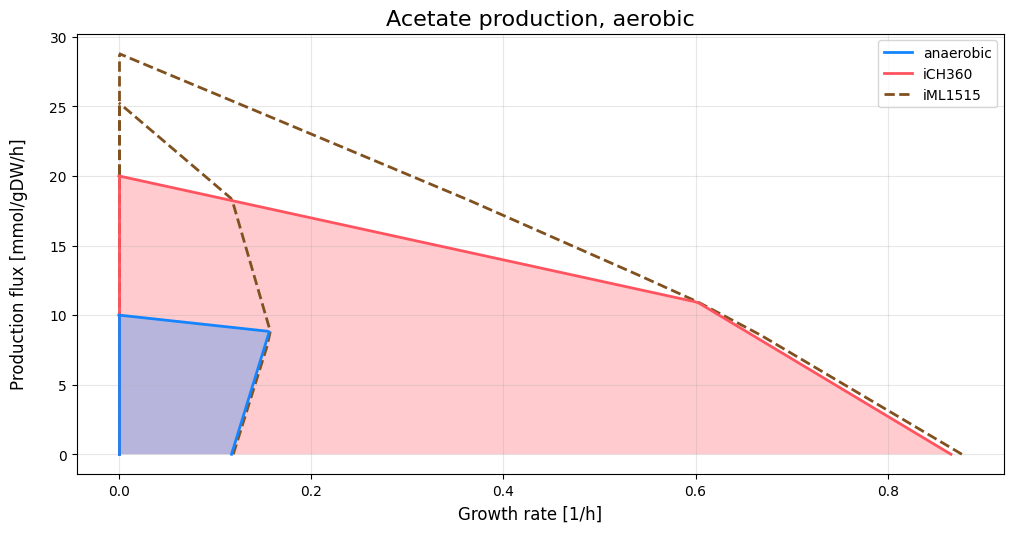

In [4]:
iml1515_KO=iml1515.copy()
carbon_source='glc__D'
products=['EX_ac_e']
fig,ax=plt.subplots(1,1,figsize=(10,5),sharex=True,sharey=True)
ax=np.array([ax]).reshape(1,1)
plt.tight_layout()

for k,product in tqdm.tqdm(enumerate(products)):
    coords=np.unravel_index(k,ax.shape)
        #iML1515======
    #aerobic
    fba_utils.plot_envelope(wt_model=iml1515_KO,
                        knockouts=[],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        color=iml1515_color,
                        ls='--',
                        label=f'iML1515',
                        fill=False)
    #anaerobic
    fba_utils.plot_envelope(wt_model=iml1515_KO,
                        knockouts=['EX_o2_e'],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        color=iml1515_color,
                        label=None,
                        ls='--',
                        fill=False)
    #=======
    #iCH360 (left)======
    #aerobic
    fba_utils.plot_envelope(wt_model=ich360,
                        knockouts=[],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        label='iCH360',
                        color=aerobic_color)
    #anaerobic
    fba_utils.plot_envelope(wt_model=ich360,
                        knockouts=['EX_o2_e'],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        label='anaerobic',
                        color=anaerobic_color)
    ax[coords].set_title(f'Acetate production, aerobic',fontsize=16)
    ax[coords].grid(alpha=grid_alpha)

ax[0,0].legend(reverse=True)
fig.supxlabel('Growth rate [1/h]',y=-0.02)
fig.supylabel('Production flux [mmol/gDW/h]',x=-0.02)

As one can see, the genome scale model can produce significantly more acetate, both aerobically and anaerobically, than iCH360. In the rest of this notebook, we investigate the reasons for this behaviour and assess whether this is likely due to errors in iCH360, or unrealistic predictions from the genome-scale parent.

# How is acetate produced in both models?

Let's start by assessing the production routes for acetate in both models

In [5]:
with iml1515 as m:
    m.objective='EX_ac_e'
    sol=m.optimize()
    acetate_production=m.metabolites.ac_c.summary()
    acetyl_phosphate_production=m.metabolites.actp_c.summary()
print(acetate_production)
print('\n\n')
print(acetyl_phosphate_production)

ac_c
====
Formula: C2H3O2

Producing Reactions
-------------------
Percent Flux Reaction                      Definition
100.00% 28.8     ACKr ac_c + atp_c <=> actp_c + adp_c

Consuming Reactions
-------------------
Percent  Flux Reaction                Definition
100.00% -28.8  ACt2rpp ac_p + h_p <=> ac_c + h_c



actp_c
Formula: C2H3O5P

Producing Reactions
-------------------
Percent Flux Reaction                        Definition
100.00% 28.8     PTAr accoa_c + pi_c <=> actp_c + coa_c

Consuming Reactions
-------------------
Percent  Flux Reaction                      Definition
100.00% -28.8     ACKr ac_c + atp_c <=> actp_c + adp_c


In [6]:
with ich360 as m:
    m.objective='EX_ac_e'
    sol=m.optimize()
    acetate_production=m.metabolites.ac_c.summary()
    acetyl_phosphate_production=m.metabolites.actp_c.summary()
print(acetate_production)
print('\n\n')
print(acetyl_phosphate_production)

ac_c
====
Formula: C2H3O2

Producing Reactions
-------------------
Percent Flux Reaction                      Definition
100.00%   20     ACKr ac_c + atp_c <=> actp_c + adp_c

Consuming Reactions
-------------------
Percent Flux Reaction                Definition
100.00%  -20  ACt2rpp ac_p + h_p <=> ac_c + h_c



actp_c
Formula: C2H3O5P

Producing Reactions
-------------------
Percent Flux Reaction                        Definition
100.00%   20     PTAr accoa_c + pi_c <=> actp_c + coa_c

Consuming Reactions
-------------------
Percent Flux Reaction                      Definition
100.00%  -20     ACKr ac_c + atp_c <=> actp_c + adp_c


As we can see, both models are producing acetate entirely from acetyl-CoA (via acetyl phosphate). Hence, we will concentrate our analysis of the differences in the two models towards the differences in production of acetyl-CoA.

# Aerobic conditions

Under aerobic conditions, iCH360 produces all of its acetyl-CoA via pyruvate oxidation, via either PDH or PFL:

In [7]:
with ich360 as m:
    m.objective='EX_ac_e'
    sol=m.optimize()
    out=m.metabolites.accoa_c.summary()
print('aerobic Production of acetyl-CoA in iml1515:')
print(out.producing_flux.query("percent>0"))
print('\n')

print('If PFL is knocked out, all flux becomes carried by PDH:')
print('aerobic Production of acetyl-CoA in iml1515 after PFL KO:')
with ich360 as m:
    m.objective='EX_ac_e'
    m.reactions.PFL.knock_out()
    sol=m.optimize()
    out=m.metabolites.accoa_c.summary()
print(out.producing_flux.query("percent>0"))
print('\n')

print('A double PDH/PFL KO annhilate acetyl-CoA production entirely:')
print('aerobic Production of acetyl-CoA in iCH360 after PFL/PDH KO:')
with ich360 as m:
    m.objective='EX_ac_e'
    m.reactions.PFL.knock_out()
    m.reactions.PDH.knock_out()
    sol=m.optimize()
    out=m.metabolites.accoa_c.summary()
print(out.producing_flux.query("percent>0"))
print('\n')

aerobic Production of acetyl-CoA in iml1515:
     flux reaction  percent
PFL  20.0      PFL      1.0


If PFL is knocked out, all flux becomes carried by PDH:
aerobic Production of acetyl-CoA in iml1515 after PFL KO:
     flux reaction  percent
PDH  20.0      PDH      1.0


A double PDH/PFL KO annhilate acetyl-CoA production entirely:
aerobic Production of acetyl-CoA in iCH360 after PFL/PDH KO:
Empty DataFrame
Columns: [flux, reaction, percent]
Index: []




This result is well expected and in line with literature understanding that the majority of acetyl-CoA in E. coli is produced from pyruvate oxidation

Looking at iML1515, the situation becomes more complex. The genome-scale model is able to leverage a number of degradation pathways to produce acetyl-CoA, either directly, or via aceteldehyde, which is then converted into acetyl-CoA by acetaldehyde dehydrogenase (ACALD):

<figure>
<img src="./images/aerobic_acetate_production_in_iML1515.png" width=500"  style="display:block;margin-left:auto;margin-right:auto;">
</figure>



In [8]:
with iml1515 as m:
    m.objective='EX_ac_e'
    sol=m.optimize()
    out=m.metabolites.accoa_c.summary()
print('aerobic Production of acetyl-CoA in iml1515:')
print(out.producing_flux.query("percent>0"))
print('\n')


aerobic Production of acetyl-CoA in iml1515:
            flux reaction   percent
ACALD  14.397588    ACALD  0.500000
PFL     5.993970      PFL  0.208159
POR5    8.403618     POR5  0.291841




Indeed, blocking acetyl-coA production from pyruvate entirely via a triple knockout (PFL,PDH,POR5) results in the model still being able to produce considerable amounts of acetyl-CoA, which is likely unrealistic in practice:

In [9]:
with iml1515 as m:
    m.objective='EX_ac_e'
    for ko_rxn in ['PDH','PFL','POR5']:
        m.reactions.get_by_id(ko_rxn).knock_out()
    sol=m.optimize()
    out=m.metabolites.accoa_c.summary()
print('aerobic Production of acetyl-CoA in iml1515:')
print(out.producing_flux.query("percent>0"))
print('\n')


aerobic Production of acetyl-CoA in iml1515:
            flux reaction  percent
ACALD  21.036522    ACALD      1.0




In light of this, we can understand te differences in the production envelopes shown at the start: at low growth rates, these degradative routes can occupy up to 50% of acetate production, causing the difference between the two envelopes. At higher growth rates, the degradative routes becomes less and less favourable, and the genome-scale model starts producing all of its acetyl-CoA from pyruvate oxidation, at which point the two envelopes converge together.

We can observe this by computing the fraction of acetyl-CoA produced glycolytically (i.e. from pyruvate oxidation) along the pareto front of the network (i.e. the upper edge of the production envelope):

Text(0, 0.5, 'Fraction of Ac-CoA produced glycolytically')

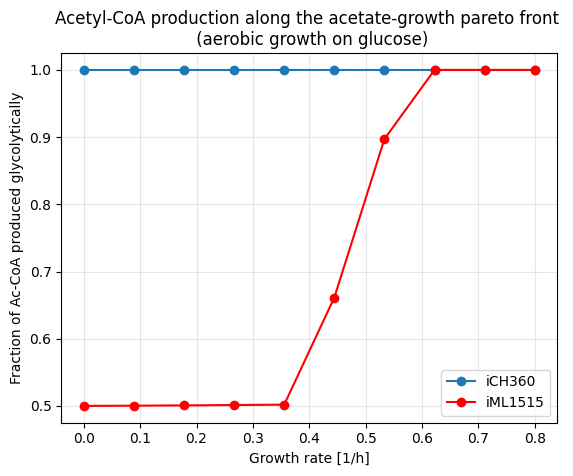

In [10]:

iml1515_biomass_rxn='BIOMASS_Ec_iML1515_core_75p37M'
biomass_ar=np.linspace(0, 0.8, 10)
iml1515_glycolytic_accoa_flux=np.zeros(biomass_ar.shape)
iml1515_all_accoa_flux=np.zeros(biomass_ar.shape)

ich360_biomass_rxn='Biomass'
ich360_glycolytic_accoa_flux=np.zeros(biomass_ar.shape)
ich360_all_accoa_flux=np.zeros(biomass_ar.shape)

for i, v_bm in enumerate(biomass_ar):
    with iml1515 as m:
        #Fix biomass flux and optimise for acetate
        m.reactions.get_by_id(iml1515_biomass_rxn).lower_bound=v_bm
        m.reactions.get_by_id(iml1515_biomass_rxn).upper_bound=v_bm
        m.objective='EX_ac_e'
        sol=m.optimize()
        iml1515_all_accoa_flux[i]=m.metabolites.accoa_c.summary().producing_flux.flux.sum()
        iml1515_glycolytic_accoa_flux[i]=m.metabolites.accoa_c.summary().producing_flux.flux.loc[['PDH','PFL','POR5']].sum()
    #repeat for ich360
    with ich360 as m:
        m.reactions.get_by_id(ich360_biomass_rxn).lower_bound=v_bm
        m.reactions.get_by_id(ich360_biomass_rxn).upper_bound=v_bm
        m.objective='EX_ac_e'
        sol=m.optimize()
        ich360_all_accoa_flux[i]=m.metabolites.accoa_c.summary().producing_flux.flux.sum()
        ich360_glycolytic_accoa_flux[i]=m.metabolites.accoa_c.summary().producing_flux.flux.loc[['PDH','PFL']].sum()

import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(biomass_ar,ich360_glycolytic_accoa_flux/ich360_all_accoa_flux,'-o',label='iCH360')
ax.plot(biomass_ar,iml1515_glycolytic_accoa_flux/iml1515_all_accoa_flux,'-o',label='iML1515',color='red')
ax.legend()
ax.set_title('Acetyl-CoA production along the acetate-growth pareto front \n (aerobic growth on glucose)')
ax.grid(alpha=grid_alpha)
ax.set_xlabel('Growth rate [1/h]')
ax.set_ylabel('Fraction of Ac-CoA produced glycolytically')

Finally, we show that blocking the degradative routes in iML1515 results in comparable acetate production envelopes with iCH360

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp5yt27qql.lp
Reading time = 0.05 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


0it [00:00, ?it/s]

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp434fovh8.lp
Reading time = 0.05 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp6lggr4zy.lp
Reading time = 0.03 seconds
: 304 rows, 698 columns, 2988 nonzeros


1it [00:21, 21.14s/it]


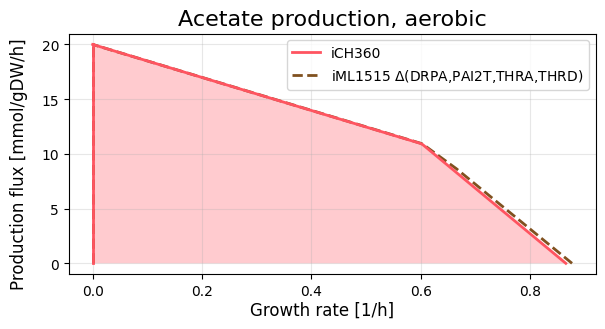

In [11]:
iml1515_KO=iml1515.copy()
KO_reactions=['DRPA','PAI2T','THRA','THRD']
for rxn in KO_reactions:
    iml1515_KO.reactions.get_by_id(rxn).knock_out()
carbon_source='glc__D'
products=['EX_ac_e']
aerobic_color="#ff5460ff"
anaerobic_color="#1484ffff"
iml1515_color='#80511f'
fig,ax=plt.subplots(1,1,figsize=(6,3),sharex=True,sharey=True)
ax=np.array([ax]).reshape(1,1)
plt.tight_layout()

for k,product in tqdm.tqdm(enumerate(products)):
    coords=np.unravel_index(k,ax.shape)
        #iML1515======
    #aerobic
    fba_utils.plot_envelope(wt_model=iml1515_KO,
                        knockouts=[],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        color=iml1515_color,
                        ls='--',
                        label=f'iML1515 ' +r'$\Delta$'+'(' + ','.join(KO_reactions) +')',
                        fill=False)
    #=======
    #iCH360 (left)======
    #aerobic
    fba_utils.plot_envelope(wt_model=ich360,
                        knockouts=[],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        label='iCH360',
                        color=aerobic_color)
    ax[coords].set_title(f'Acetate production, aerobic',fontsize=16)
    ax[coords].grid(alpha=grid_alpha)

ax[0,0].legend(reverse=True,loc='upper right')
fig.supxlabel('Growth rate [1/h]',y=-0.02)
fig.supylabel('Production flux [mmol/gDW/h]',x=-0.02)
fig.savefig('../figures/acetate_production_iml1515_KO.svg')


# Anaerobic conditions
Under anaerobic conditions, the situation is further complicated by the fact that iML1515 is able to produce more pyruvate than iML1515 (which in turns results in higher acetyl-CoA production and hence acetate). We can see this by looking into the pyruvate production envelope under anaerobic conditions:

0it [00:00, ?it/s]

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp7y7b7alz.lp
Reading time = 0.04 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmpk_3w1hen.lp
Reading time = 0.07 seconds
: 304 rows, 698 columns, 2988 nonzeros


1it [00:20, 20.00s/it]


Text(-0.02, 0.5, 'Production flux [mmol/gDW/h]')

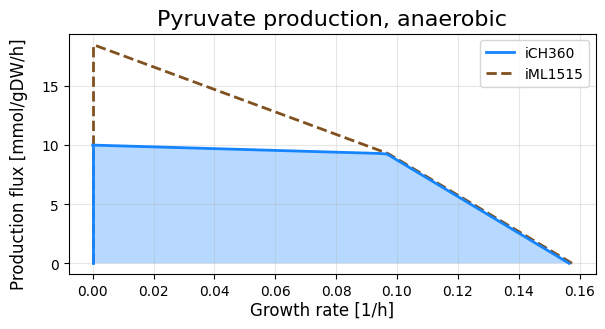

In [12]:
carbon_source='glc__D'
products=['EX_pyr_e']
product_names=['Pyruvate']
anaerobic_color="#1484ffff"
iml1515_color='#80511f'
fig,ax=plt.subplots(1,1,figsize=(6,3),sharex=True,sharey=True)
ax=np.array([ax]).reshape(1,1)
plt.tight_layout()

for k,product in tqdm.tqdm(enumerate(products)):
    coords=np.unravel_index(k,ax.shape)
        #iML1515======
    #anaerobic
    fba_utils.plot_envelope(wt_model=iml1515,
                    knockouts=['EX_o2_e'],
                    carbon_sources=[carbon_source],
                    target_reaction=product,
                    ax=ax[coords],
                    color=iml1515_color,
                    label='iML1515',
                    ls='--',
                    fill=False)
    #=======
    #anaerobic
    fba_utils.plot_envelope(wt_model=ich360,
                        knockouts=['EX_o2_e'],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        label='iCH360',
                        color=anaerobic_color)
    ax[coords].set_title(f'{product_names[k]} production, anaerobic',fontsize=16)
    ax[coords].grid(alpha=grid_alpha)

ax[0,0].legend(reverse=True)
fig.supxlabel('Growth rate [1/h]',y=-0.02)
fig.supylabel('Production flux [mmol/gDW/h]',x=-0.02)


Inspecting this behaviour, we found that iMl1515 can uptake external CO2 and use it as a sink for glycolytic electron, generating pyruvate by running POR5 in reverse:

In [13]:
with iml1515 as m:
    m.objective='EX_pyr_e'
    m.optimize()
    out=m.metabolites.co2_c.summary()
print(out)

co2_c
=====
Formula: CO2

Producing Reactions
-------------------
Percent Flux Reaction      Definition
100.00% 9.17   CO2tpp co2_p <=> co2_c

Consuming Reactions
-------------------
Percent   Flux Reaction                                                         Definition
 66.67% -6.113     POR5 coa_c + 2.0 flxso_c + pyr_c <=> accoa_c + co2_c + 2.0 flxr_c + h_c
 33.33% -3.057      PPC                       co2_c + h2o_c + pep_c --> h_c + oaa_c + pi_c


<figure>
<img src="./images/co2_as_electron_sink.png" width=600"  style="display:block;margin-left:auto;margin-right:auto;">
</figure>


Interestingly, we found that blocking CO2 uptake can reduce pyruvate production, but the gap with iCH360 is not yet closed, implying that the genome-scale model has additional ways to dissipate excess glycolytic electrons, and hence produce more pyruvate anaerobically:

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmpwtn9hfca.lp
Reading time = 0.08 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


0it [00:00, ?it/s]

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmpckycxut8.lp
Reading time = 0.10 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp5qusq9fq.lp
Reading time = 0.04 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmplvmshvau.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros


1it [00:36, 36.74s/it]


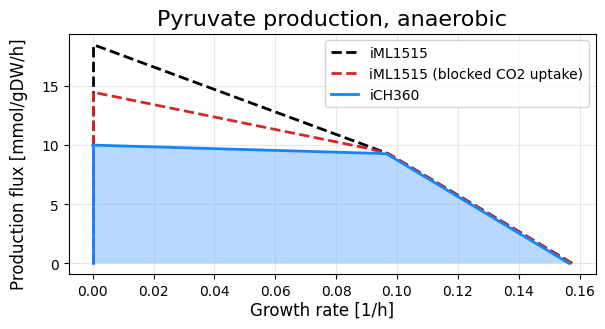

In [14]:
iml1515_no_co2_uptake=iml1515.copy()
iml1515_no_co2_uptake.reactions.EX_co2_e.lower_bound=0.
carbon_source='glc__D'
products=['EX_pyr_e']
product_names=['Pyruvate']
anaerobic_color="#1484ffff"
iml1515_color='#bd995bff'
fig,ax=plt.subplots(1,1,figsize=(6,3),sharex=True,sharey=True)
ax=np.array([ax]).reshape(1,1)
plt.tight_layout()

for k,product in tqdm.tqdm(enumerate(products)):
    coords=np.unravel_index(k,ax.shape)
        #iML1515======
    #anaerobic
    fba_utils.plot_envelope(wt_model=iml1515,
                    knockouts=['EX_o2_e'],
                    carbon_sources=[carbon_source],
                    target_reaction=product,
                    ax=ax[coords],
                    color='black',
                    label='iML1515',
                    ls='--',
                    fill=False)
    #=======
    fba_utils.plot_envelope(wt_model=iml1515_no_co2_uptake,
                        knockouts=['EX_o2_e'],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        color='tab:red',
                        label='iML1515 (blocked CO2 uptake)',
                        ls='--',
                        fill=False)
    #=======
    fba_utils.plot_envelope(wt_model=ich360,
                        knockouts=['EX_o2_e'],
                        carbon_sources=[carbon_source],
                        target_reaction=product,
                        ax=ax[coords],
                        label='iCH360',
                        color=anaerobic_color)
    ax[coords].set_title(f'{product_names[k]} production, anaerobic',fontsize=16)
    ax[coords].grid(alpha=grid_alpha)

ax[0,0].legend(reverse=False)
ax[0,0].grid(alpha=grid_alpha)
fig.supxlabel('Growth rate [1/h]',y=-0.02)
fig.supylabel('Production flux [mmol/gDW/h]',x=-0.02)

for extension in ['svg']:
    fig.savefig(f'../figures/ich360_vs_iml1515_anaerobic_pyruvate_production.{extension}',
                bbox_inches='tight',
                )